In [116]:
# import spacec first
import spacec as sp

# import standard packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
import igraph as ig
import leidenalg
import umap

# silencing warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Specify the path to the data
root_path = "/Users/jessica/Intership_ss2025/" # replace with your path
data_path = root_path + 'example_data/raw/' # where the data is stored

# where you want to store the output
output_dir = root_path + 'example_data/output/'
os.makedirs(output_dir, exist_ok=True)

In [17]:
#read in segmentation csv files
#Read and concatenate the csv files (outputs from the cell segmentation algorithms). 
df_se_cellpose = sp.pp.read_segdf(
    segfile_list = [ # list of segmented files 
        output_dir + "region_3_cellpose_cellpose_result.csv"
    ],
    seg_method = 'cellpose',
    region_list =["reg003"],
    meta_list = None
)

#Get the shape of the data
print(df_se_cellpose.shape)

#See what it looks like
df_se_cellpose.head()

#read in segmentation csv files
#Read and concatenate the csv files (outputs from the cell segmentation algorithms). 
df_se_mesmer = sp.pp.read_segdf(
    segfile_list = [ # list of segmented files 
        output_dir + "region_3_mesmer_mesmer_result.csv"
    ],
    seg_method = 'mesmer',
    region_list =["reg003"],
    meta_list = None
)

#Get the shape of the data
print(df_se_mesmer.shape)

#See what it looks like
df_se_mesmer.head()

(1448, 21)
(2009, 21)


,DAPI,Ki67,Keratin5,CD68,Podoplanin,SMA,CD107a,CLDN17,CD34,HLA-DR,...,x,eccentricity,perimeter,convex_area,area,axis_major_length,axis_minor_length,label,region_num,unique_region
1,29.723577,0.036585,0.313008,0.703252,0.186992,0.410569,0.686992,0.272358,1.313008,0.434959,...,1255.764228,0.274530,55.455844,251.0,246.0,18.067477,17.373298,1,0,reg003
2,15.873418,0.000000,0.000000,0.050633,0.101266,9.911392,0.569620,0.075949,0.683544,0.164557,...,1220.443038,0.267586,30.142136,82.0,79.0,10.205445,9.833292,2,0,reg003
3,18.387500,0.012500,0.031250,0.393750,0.156250,0.606250,0.231250,0.293750,0.162500,0.212500,...,1148.218750,0.793606,47.213203,171.0,160.0,18.308091,11.139235,3,0,reg003
4,12.954545,0.045455,0.045455,0.772727,0.000000,0.045455,0.636364,0.500000,0.000000,0.409091,...,1311.909091,0.428259,14.242641,22.0,22.0,5.502817,4.972652,4,0,reg003
5,64.929577,0.014085,1.077465,0.098592,0.239437,6.366197,1.492958,0.049296,1.366197,0.450704,...,1226.633803,0.681299,42.384776,149.0,142.0,15.708799,11.498917,5,0,reg003


In [18]:
one_percent_area_cellpose = np.percentile(df_se_cellpose.area, 1)
one_percent_area_cellpose
one_percent_area_mesmer = np.percentile(df_se_mesmer.area, 1)
one_percent_area_mesmer

21.0

In [19]:
one_percent_nuc_cellpose = np.percentile(df_se_cellpose.DAPI, 1)
one_percent_nuc_cellpose

one_percent_nuc_mesmer = np.percentile(df_se_mesmer.DAPI, 1)
one_percent_nuc_mesmer


12.605333333333332

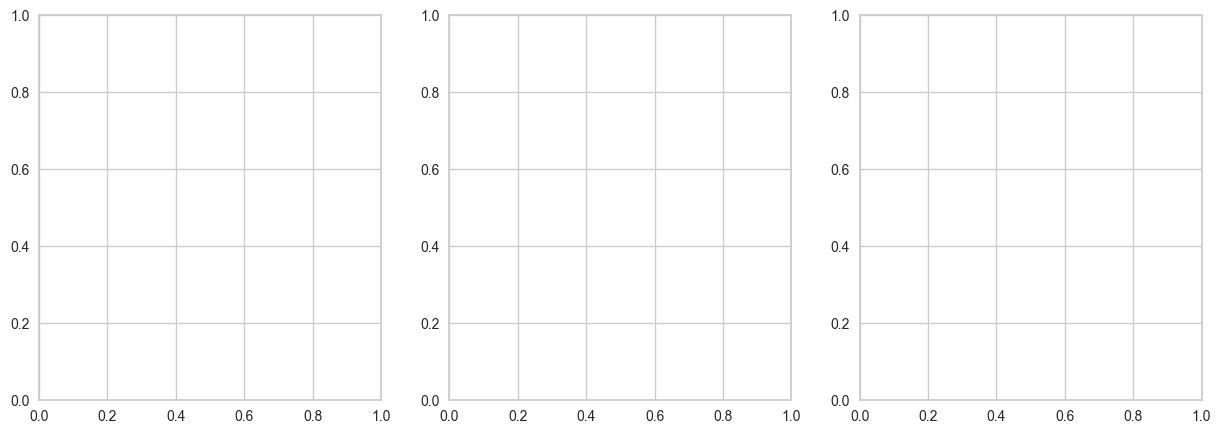

In [20]:
# If necessary filter the dataframe to remove too small objects or cells without a nucleus. 
# Identify the lowest 1% for cell size and nuclear marker intensity to get a better idea of potential segmentation artifacts.
df_filt_cellpose = sp.pp.filter_data(df_se_cellpose, 
    nuc_thres=one_percent_nuc_cellpose, # remove cells with DAPI intensity below threshold
    size_thres=one_percent_area_cellpose, # remove cells with area below threshold
    nuc_marker="DAPI", # name of nuclear marker
    cell_size = "area", # name of cell size column
    region_column = "region_num",       # 如果 df_seg 中没有 region_num 就设为 None
    color_by = "region_num",            # 同上
    log_scale=False) # log scale for size


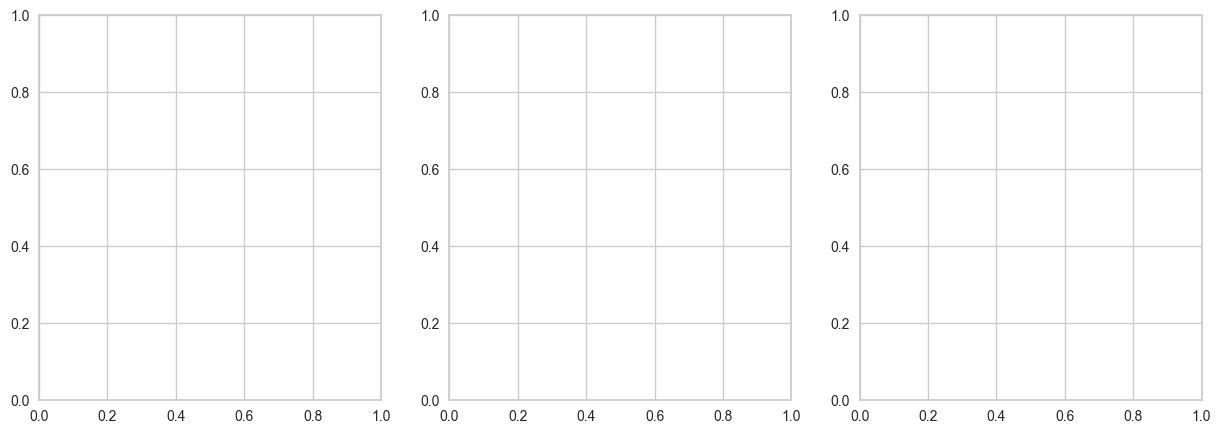

In [21]:
# If necessary filter the dataframe to remove too small objects or cells without a nucleus. 
# Identify the lowest 1% for cell size and nuclear marker intensity to get a better idea of potential segmentation artifacts.
df_filt_mesmer = sp.pp.filter_data(df_se_mesmer, 
    nuc_thres=one_percent_nuc_mesmer, # remove cells with DAPI intensity below threshold
    size_thres=one_percent_area_mesmer, # remove cells with area below threshold
    nuc_marker="DAPI", # name of nuclear marker
    cell_size = "area", # name of cell size column
    region_column = "region_num",       # 如果 df_seg 中没有 region_num 就设为 None
    color_by = "region_num",            # 同上
    log_scale=False) # log scale for size


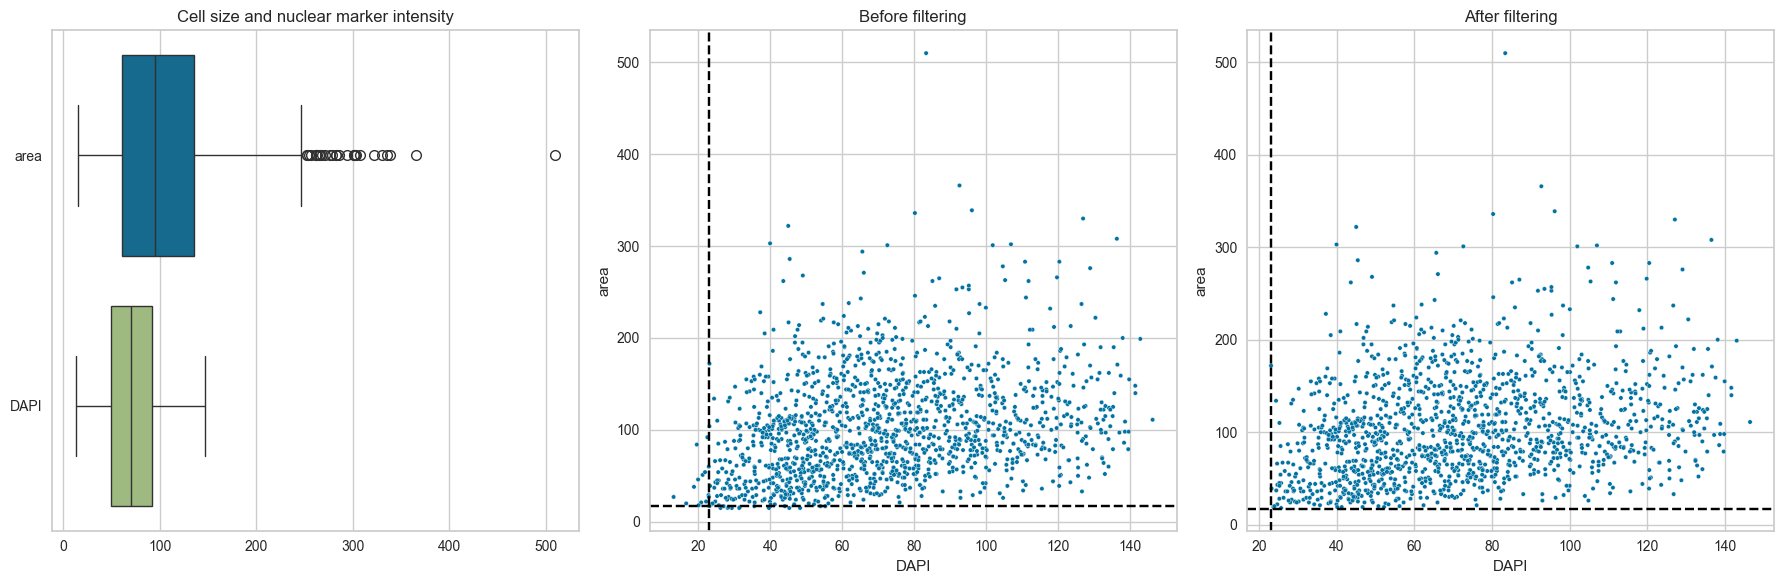

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 你可以改成 (12, 4), (20, 8) 等

# 左图：箱线图
sns.boxplot(data=df_se_cellpose[["area", "DAPI"]], orient='h', ax=axs[0])
axs[0].set_title("Cell size and nuclear marker intensity")

# 中图：filter 前
sns.scatterplot(data=df_se_cellpose, x="DAPI", y="area", hue="region_num", s=10, ax=axs[1], legend=False)
axs[1].axvline(one_percent_nuc_cellpose, color="black", linestyle="--")
axs[1].axhline(one_percent_area_cellpose, color="black", linestyle="--")
axs[1].set_title("Before filtering")

# 右图：filter 后
sns.scatterplot(data=df_filt_cellpose, x="DAPI", y="area", hue="region_num", s=10, ax=axs[2], legend=False)
axs[2].axvline(one_percent_nuc_cellpose, color="black", linestyle="--")
axs[2].axhline(one_percent_area_cellpose, color="black", linestyle="--")
axs[2].set_title("After filtering")

plt.tight_layout()
plt.show()

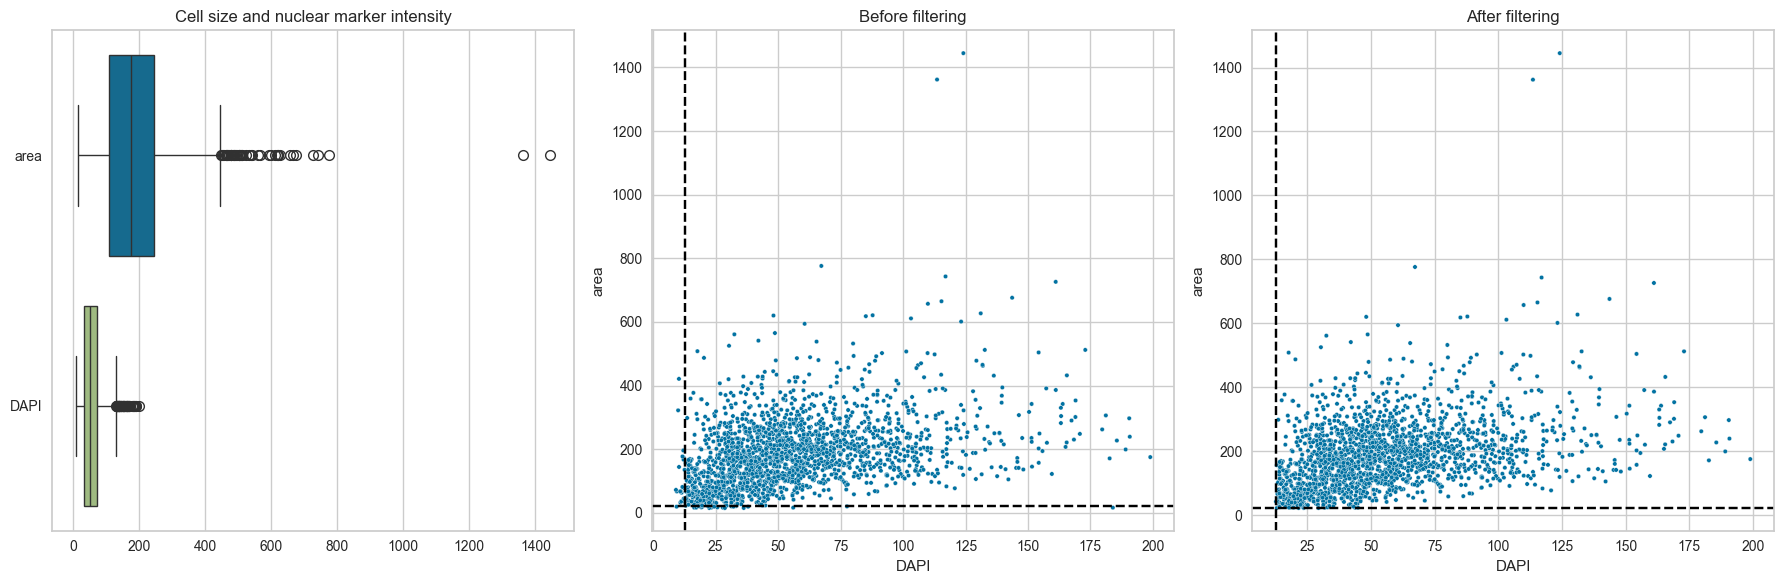

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 你可以改成 (12, 4), (20, 8) 等

# 左图：箱线图
sns.boxplot(data=df_se_mesmer[["area", "DAPI"]], orient='h', ax=axs[0])
axs[0].set_title("Cell size and nuclear marker intensity")

# 中图：filter 前
sns.scatterplot(data=df_se_mesmer, x="DAPI", y="area", hue="region_num", s=10, ax=axs[1], legend=False)
axs[1].axvline(one_percent_nuc_mesmer, color="black", linestyle="--")
axs[1].axhline(one_percent_area_mesmer, color="black", linestyle="--")
axs[1].set_title("Before filtering")

# 右图：filter 后
sns.scatterplot(data=df_filt_mesmer, x="DAPI", y="area", hue="region_num", s=10, ax=axs[2], legend=False)
axs[2].axvline(one_percent_nuc_mesmer, color="black", linestyle="--")
axs[2].axhline(one_percent_area_mesmer, color="black", linestyle="--")
axs[2].set_title("After filtering")

plt.tight_layout()
plt.show()

In [24]:
len(df_filt_cellpose)


1416

In [26]:
len(df_filt_mesmer)

1965

In [27]:
#### Normalization #####

df_filt_cellpose.columns


Index(['DAPI', 'Ki67', 'Keratin5', 'CD68', 'Podoplanin', 'SMA', 'CD107a',
       'CLDN17', 'CD34', 'HLA-DR', 'y', 'x', 'eccentricity', 'perimeter',
       'convex_area', 'area', 'axis_major_length', 'axis_minor_length',
       'label', 'region_num', 'unique_region'],
      dtype='object')

In [ ]:
# This is to normalize the data per region/tif
dfz_1 = pd.DataFrame()

for region in df_filt_cellpose.unique_region.unique():
    df_reg = df_filt_cellpose[df_filt_cellpose.unique_region == region]
    df_reg_norm = sp.pp.format(
        data=df_reg, 
        list_out= ['eccentricity', 'perimeter', 'convex_area', 'axis_major_length', 'axis_minor_length',  "label"], # list of features to remove
        list_keep = ["DAPI",'x','y', 'area','region_num',"unique_region"], 
        method = "zscore") # choose from "zscore", "double_zscore", "MinMax", "ArcSin"
    dfz_1 = pd.concat([dfz_1,df_reg_norm], axis = 0)

dfz_1.shape


(1416, 15)

In [33]:
# This is to normalize the data per region/tif
dfz_2 = pd.DataFrame()

for region in df_filt_cellpose.unique_region.unique():
    df_reg = df_filt_cellpose[df_filt_cellpose.unique_region == region]
    df_reg_norm_1 = sp.pp.format(
        data=df_reg, 
        list_out= ['eccentricity', 'perimeter', 'convex_area', 'axis_major_length', 'axis_minor_length',  "label"], # list of features to remove
        list_keep = ["DAPI",'x','y', 'area','region_num',"unique_region"], # list of meta information that you would like to keep but don't want to normalize
        method = "double_zscore") # choose from "zscore", "double_zscore", "MinMax", "ArcSin"
    dfz_2 = pd.concat([dfz_2,df_reg_norm_1], axis = 0)

dfz_2.shape

(1416, 15)

In [35]:
# This is to normalize the data per region/tif
dfz_3 = pd.DataFrame()

for region in df_filt_cellpose.unique_region.unique():
    df_reg = df_filt_cellpose[df_filt_cellpose.unique_region == region]
    df_reg_norm_2 = sp.pp.format(
        data=df_reg, 
        list_out= ['eccentricity', 'perimeter', 'convex_area', 'axis_major_length', 'axis_minor_length',  "label"], # list of features to remove
        list_keep = ["DAPI",'x','y', 'area','region_num',"unique_region"], # list of meta information that you would like to keep but don't want to normalize
        method = "MinMax") # choose from "zscore", "double_zscore", "MinMax", "ArcSin"
    dfz_3 = pd.concat([dfz_3,df_reg_norm_2], axis = 0)

dfz_3.shape


(1416, 15)

In [36]:
# This is to normalize the data per region/tif
dfz_4 = pd.DataFrame()

for region in df_filt_cellpose.unique_region.unique():
    df_reg = df_filt_cellpose[df_filt_cellpose.unique_region == region]
    df_reg_norm_3 = sp.pp.format(
        data=df_reg, 
        list_out= ['eccentricity', 'perimeter', 'convex_area', 'axis_major_length', 'axis_minor_length',  "label"], # list of features to remove
        list_keep = ["DAPI",'x','y', 'area','region_num',"unique_region"], # list of meta information that you would like to keep but don't want to normalize
        method = "ArcSin") # choose from "zscore", "double_zscore", "MinMax", "ArcSin"
    dfz_4 = pd.concat([dfz_4,df_reg_norm_3], axis = 0)

dfz_4.shape

(1416, 15)

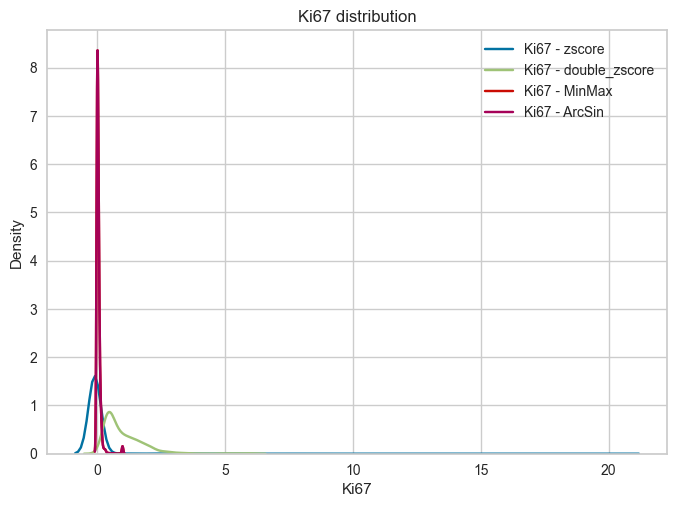

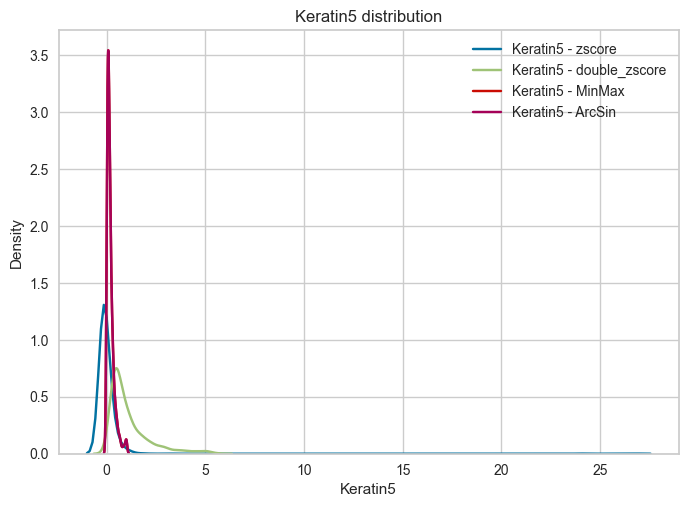

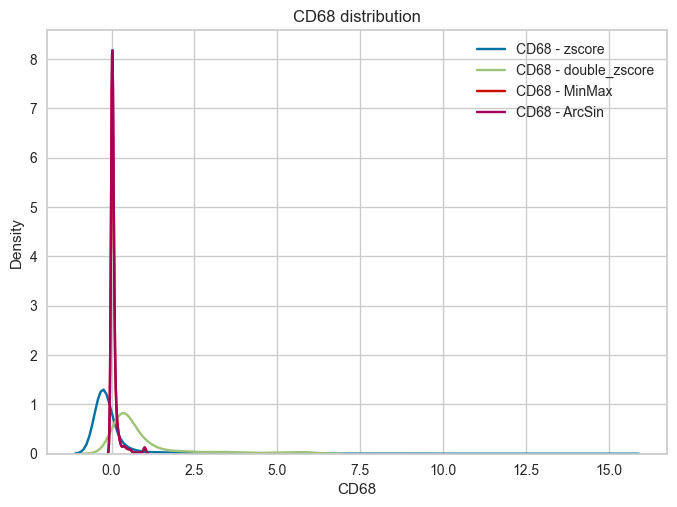

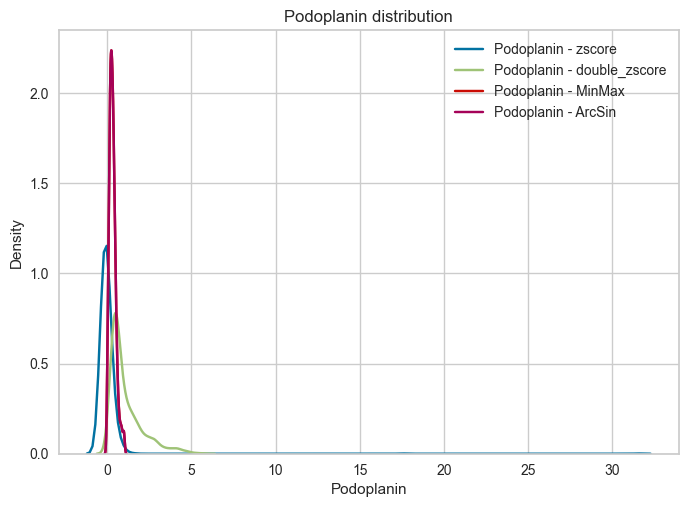

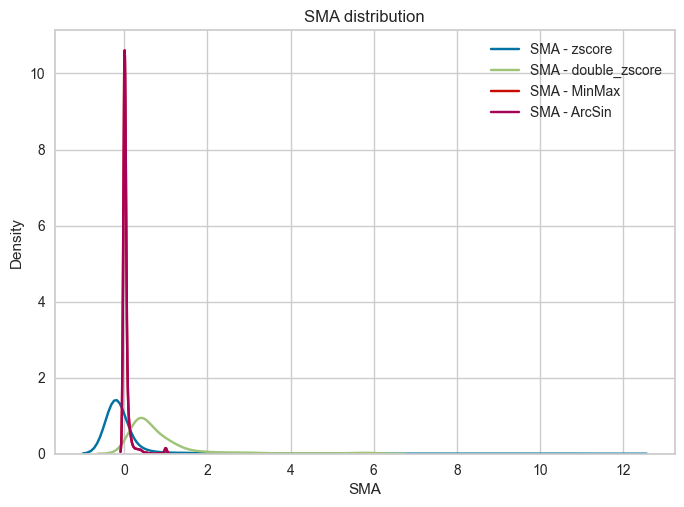

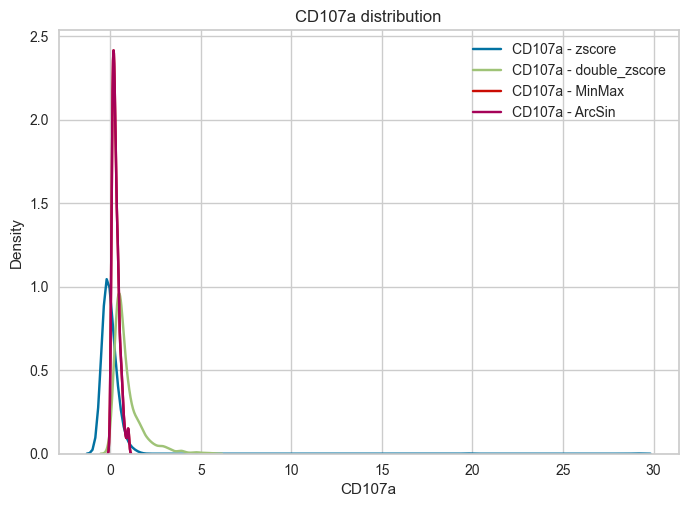

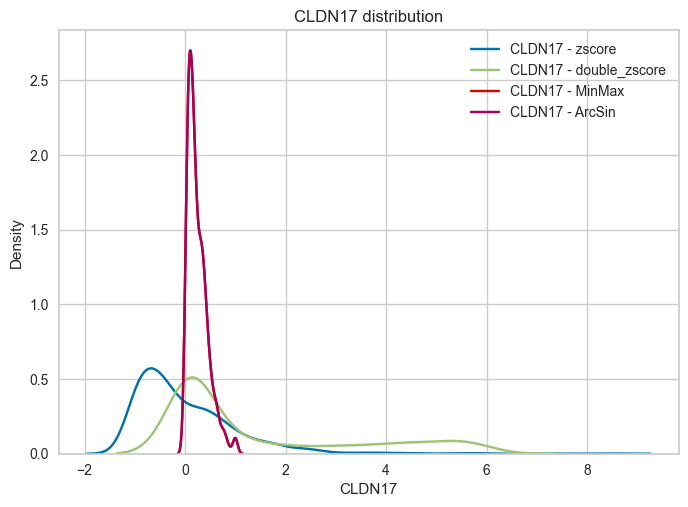

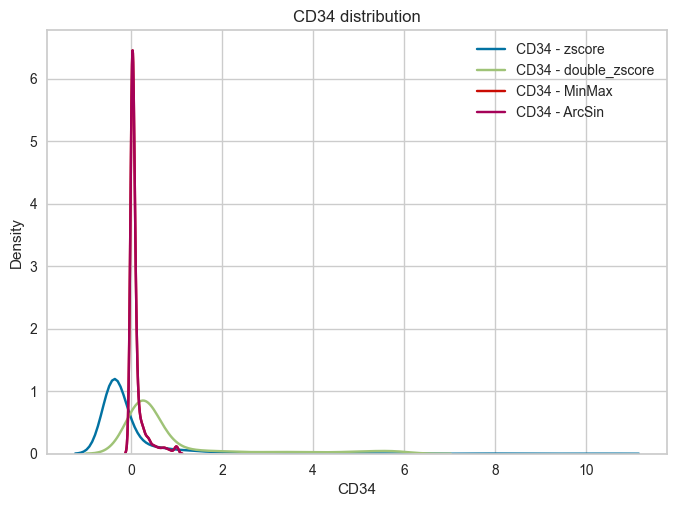

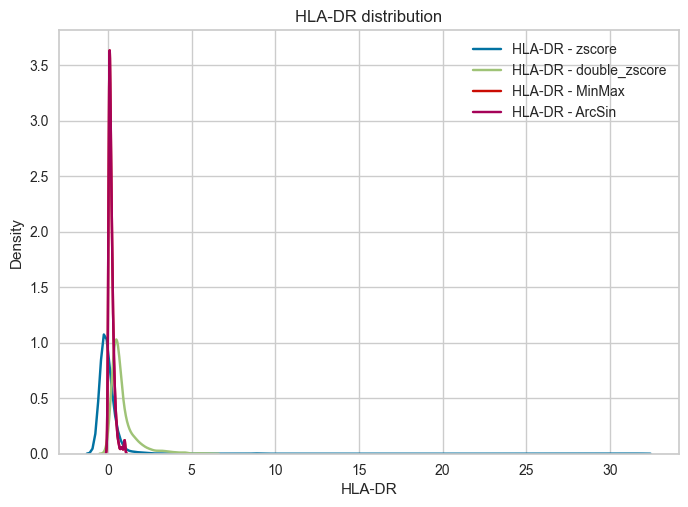

In [54]:
for marker in ['Ki67', 'Keratin5', 'CD68', 'Podoplanin', 'SMA', 'CD107a',
       'CLDN17', 'CD34', 'HLA-DR']:
    sns.kdeplot(dfz_1[marker], label=f'{marker} - zscore')
    sns.kdeplot(dfz_2[marker], label=f'{marker} - double_zscore')
    sns.kdeplot(dfz_3[marker], label=f'{marker} - MinMax')
    sns.kdeplot(dfz_3[marker], label=f'{marker} - ArcSin')
    plt.title(f'{marker} distribution')
    plt.legend()
    plt.show()

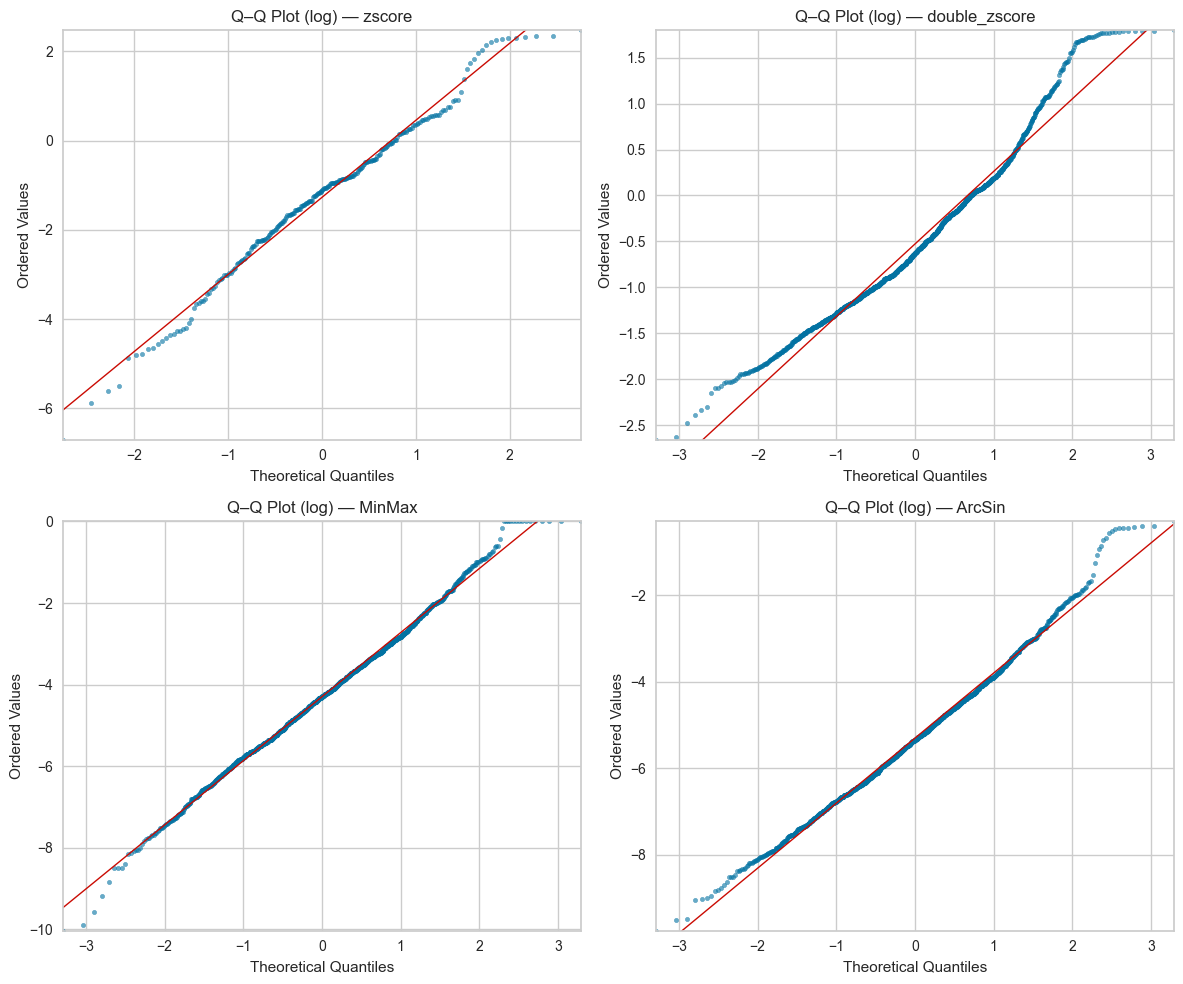

In [91]:
dfs = [dfz_1, dfz_2, dfz_3, dfz_4]
methods = ["zscore", "double_zscore", "MinMax", "ArcSin"]

plt.figure(figsize=(12, 10))
for idx, (df, method) in enumerate(zip(dfs, methods), start=1):
    ax = plt.subplot(2, 2, idx)

    data = df['SMA'].dropna()
    data = data[data > 0]

    log_data = np.log(data)

    (theo_q, obs_q), (slope, intercept, r_value) = stats.probplot(log_data, dist="norm")

    mask = np.isfinite(theo_q) & np.isfinite(obs_q)
    theo_q, obs_q = theo_q[mask], obs_q[mask]

    ax.scatter(theo_q, obs_q, s=10, alpha=0.6)
    ax.plot(theo_q, slope * theo_q + intercept, 'r-', linewidth=1)

    ax.set_xlim(theo_q.min(), theo_q.max())
    ax.set_ylim(obs_q.min(), obs_q.max())

    ax.set_title(f"Q–Q Plot (log) — {method}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Ordered Values")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [90]:
dfs     = [dfz_1, dfz_2, dfz_3, dfz_4]
methods = ["zscore", "double_zscore", "MinMax", "ArcSin"]

records = []
for df, method in zip(dfs, methods):
    x = df["SMA"].dropna()
    x = x[x > 0]
    x = np.log(x)

    stat_sw, p_sw = stats.shapiro(x)

    mu, sigma = x.mean(), x.std(ddof=1)
    stat_ks, p_ks = stats.kstest(x, "norm", args=(mu, sigma))

    records.append({
        "method":      method,
        "shapiro_p":   p_sw,
        "KS_p":        p_ks,
        "shapiro_sig": p_sw < 0.05,   # True 表示不符合正态
        "KS_sig":      p_ks < 0.05,
    })

tbl = pd.DataFrame(records)

failed = tbl[(tbl["shapiro_sig"]) | (tbl["KS_sig"])]

print("—— 所有方法检验结果 ——")
print(tbl.to_string(index=False))

print("\n—— 显著不符合正态分布的方法 ——")
if failed.empty:
    print("所有方法均未显著拒绝正态性（p ≥ 0.05）。")
else:
    print(failed[["method", "shapiro_p", "KS_p"]].to_string(index=False))

—— 所有方法检验结果 ——
       method    shapiro_p     KS_p  shapiro_sig  KS_sig
       zscore 2.738867e-02 0.500026         True   False
double_zscore 2.922769e-16 0.000100         True    True
       MinMax 1.026473e-02 0.713319         True   False
       ArcSin 4.574015e-06 0.487765         True   False

—— 显著不符合正态分布的方法 ——
       method    shapiro_p     KS_p
       zscore 2.738867e-02 0.500026
double_zscore 2.922769e-16 0.000100
       MinMax 1.026473e-02 0.713319
       ArcSin 4.574015e-06 0.487765


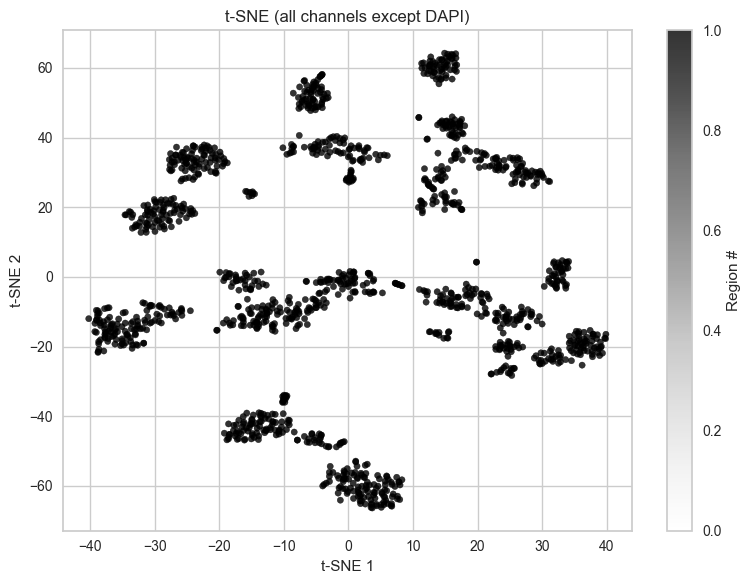

In [106]:
# 4) tf-learning 之前最好做一下标准化
X_scaled = StandardScaler().fit_transform(X)

# 5) 跑 t-SNE
tsne = TSNE(
    n_components=2, 
    perplexity=30, 
    learning_rate=200, 
    random_state=0
)
X_embedded = tsne.fit_transform(X_scaled)

# 6) 画图，这里我用 region_num 来着色，你也可以换成别的，比如 'condition'
plt.figure(figsize=(8,6))
sc = plt.scatter(
    X_embedded[:,0], X_embedded[:,1],
    c=data['region_num'],    # 换成你想的标签
    cmap='tab20',            # 也可以用 viridis, plasma…
    s=20, 
    alpha=0.8
)
plt.colorbar(sc, label='Region #')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE (all channels except DAPI)')
plt.tight_layout()
plt.show()

使用的抗体通道： ['Ki67', 'Keratin5', 'CD68', 'Podoplanin', 'SMA', 'CD107a', 'CLDN17', 'CD34', 'HLA-DR', 'leiden']


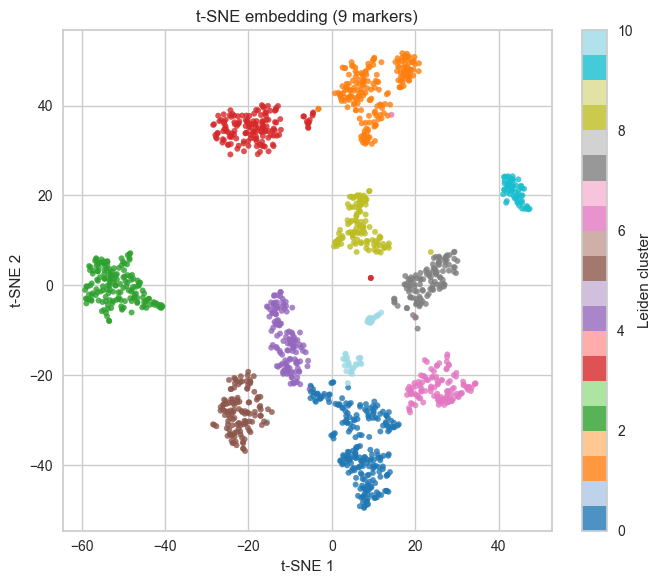

In [115]:
meta_cols = [
    'DAPI', 'x', 'y',
    'region_num', 'unique_region', 'label',
    'eccentricity','perimeter','convex_area',
    'area','axis_major_length','axis_minor_length'
]
marker_cols = [c for c in data_leiden.columns if c not in meta_cols]
print("使用的抗体通道：", marker_cols)

X = data_leiden[marker_cols].values  # shape = (n_cells, 9)

X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=0,
    n_jobs=-1
)
X_tsne = tsne.fit_transform(X_scaled)

knn_adj = kneighbors_graph(X_scaled, n_neighbors=15, mode='connectivity', include_self=False)
sources, targets = knn_adj.nonzero()
edges = list(zip(sources.tolist(), targets.tolist()))
g = ig.Graph(n=X_scaled.shape[0], edges=edges, directed=False).simplify()

partition = leidenalg.find_partition(
    g,
    leidenalg.RBConfigurationVertexPartition,
    resolution_parameter=1.0
)
labels = np.array(partition.membership)
data_leiden['leiden'] = labels

plt.figure(figsize=(7,6))
sc = plt.scatter(
    X_tsne[:,0], X_tsne[:,1],
    c=labels,
    cmap='tab20',
    s=15,
    alpha=0.8
)
plt.colorbar(sc, label='Leiden cluster')
plt.title('t-SNE embedding (9 markers)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


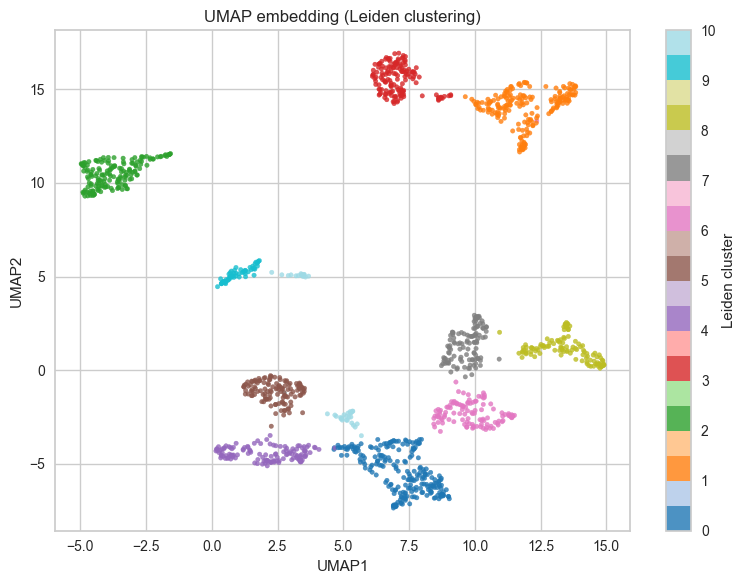

In [117]:
X_scaled = StandardScaler().fit_transform(X)

umapper = umap.UMAP(
    n_neighbors=15,      # 邻居数量，可调
    min_dist=0.3,        # 集群紧凑度，可调
    metric='euclidean',  # 距离度量
    random_state=42
)
X_umap = umapper.fit_transform(X_scaled)  # 结果形状 (n_cells, 2)

plt.figure(figsize=(8,6))
# 用 Leiden 簇着色；也可以换成 data_leiden['region_num']
scatter = plt.scatter(
    X_umap[:,0], X_umap[:,1],
    c=pd.Categorical(data_leiden['leiden']).codes,
    cmap='tab20',
    s=10,
    alpha=0.8
)

plt.colorbar(scatter, ticks=range(len(data_leiden['leiden'].unique())),
             label='Leiden cluster')
plt.title('UMAP embedding (Leiden clustering)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

In [125]:
dfz_3.columns


Index(['Ki67', 'Keratin5', 'CD68', 'Podoplanin', 'SMA', 'CD107a', 'CLDN17',
       'CD34', 'HLA-DR', 'DAPI', 'x', 'y', 'area', 'region_num',
       'unique_region'],
      dtype='object')

In [126]:
col_num_last_marker = dfz_3.columns.get_loc('HLA-DR')
print(col_num_last_marker)


8


reg003
reg003
reg003
reg003


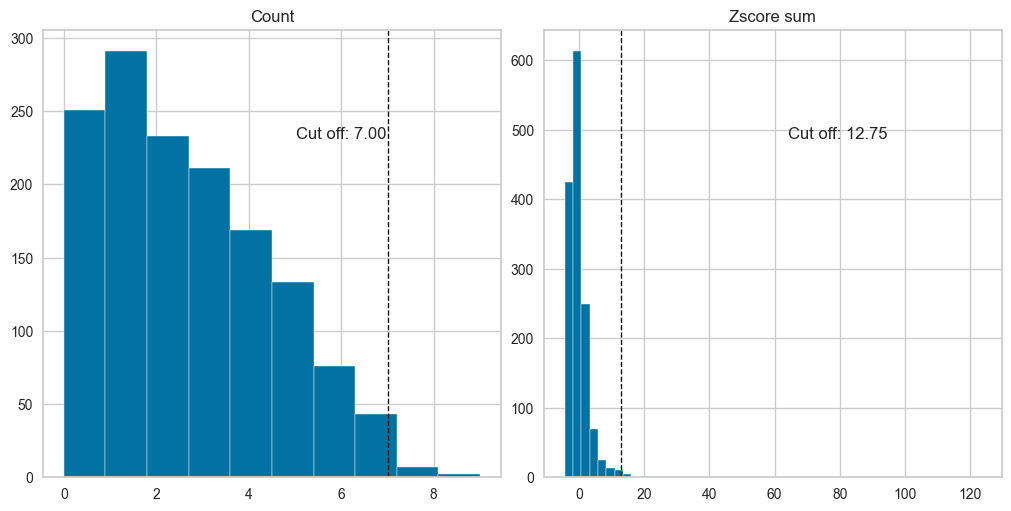

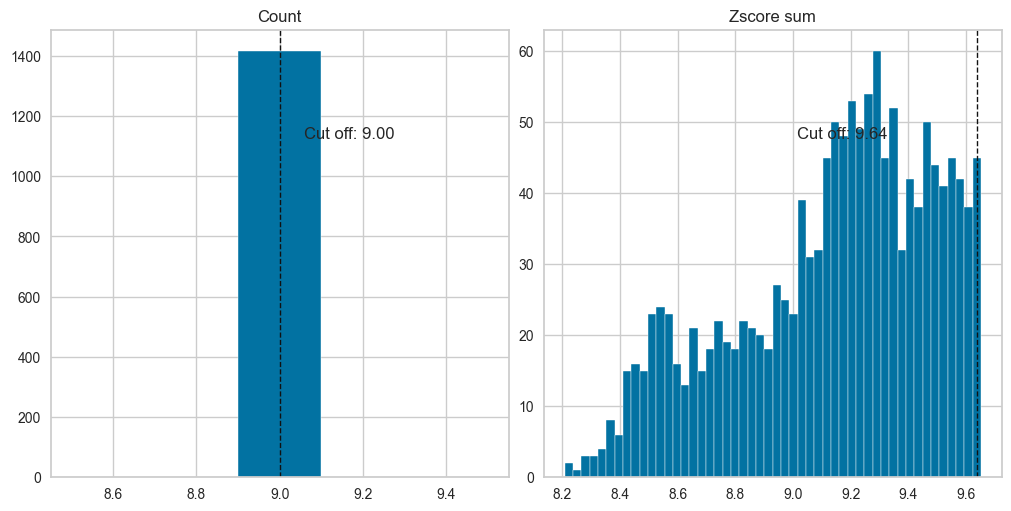

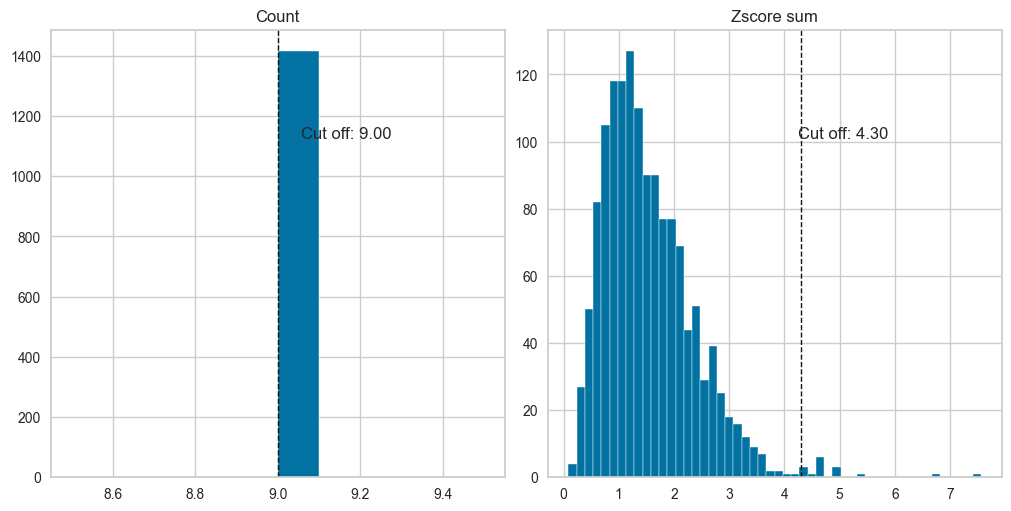

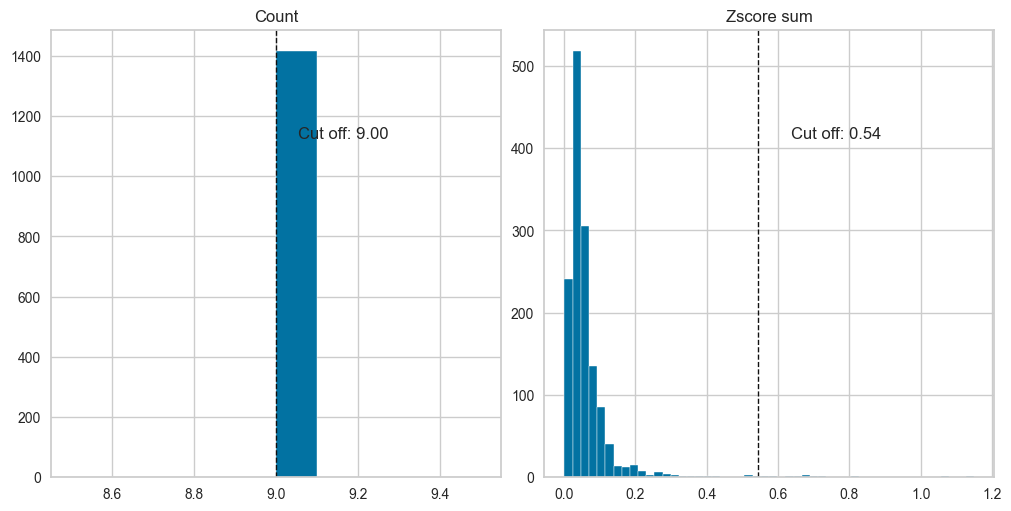

In [133]:
for region in dfz_1.unique_region.unique():
    print(region)
    df_reg = dfz_1[dfz_1.unique_region == region]
    sp.pl.zcount_thres(dfz = df_reg, 
                col_num = col_num_last_marker, # last antibody index
                cut_off=0.01, #top 1% of cells
                count_bin=10)
    
for region in dfz_2.unique_region.unique():
    print(region)
    df_reg = dfz_2[dfz_2.unique_region == region]
    sp.pl.zcount_thres(dfz = df_reg, 
                col_num = col_num_last_marker, # last antibody index
                cut_off=0.01, #top 1% of cells
                count_bin=5)

for region in dfz_3.unique_region.unique():
    print(region)
    df_reg = dfz_3[dfz_3.unique_region == region]
    sp.pl.zcount_thres(dfz = df_reg, 
                col_num = col_num_last_marker, # last antibody index
                cut_off=0.01, #top 1% of cells
                count_bin=10)
    
for region in dfz_4.unique_region.unique():
    print(region)
    df_reg = dfz_4[dfz_4.unique_region == region]
    sp.pl.zcount_thres(dfz = df_reg, 
                col_num = col_num_last_marker, # last antibody index
                cut_off=0.01, #top 1% of cells
                count_bin=10)

In [150]:
cutoff_list = [7, 12.75]
df_reg_nn, cc = sp.pp.remove_noise(
    df=df_reg, 
    col_num=col_num_last_marker,
    z_count_thres=cutoff_list[0],
    z_sum_thres=cutoff_list[1]  # ✅ 只用 z_count 作为筛选条件
)
df_reg_nn.shape


1.4000000000000001% cells are removed.


(1396, 16)

In [152]:
df_reg_nn.to_csv(output_dir + "df_reg_nn_demo.csv")


In [153]:
# inspect which markers work, and drop the ones that did not work from the clustering step
# make an anndata to be compatible with the downstream clustering step
adata = sp.hf.make_anndata(
    df_nn = df_reg_nn,
    col_sum = col_num_last_marker, # this is the column index that has the last protein feature # the rest will go into obs
    nonFuncAb_list = [] # Remove the antibodies that are not working from the clustering step
)
adata

AnnData object with n_obs × n_vars = 1396 × 9
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'unique_region', 'leiden'

In [154]:
adata.write_h5ad(output_dir + 'df_reg_nn_demo.h5ad')

... storing 'region_num' as categorical
... storing 'unique_region' as categorical


In [155]:
import pickle
with open(output_dir + 'overlay_region3_cellpose.pickle', 'rb') as f:
    overlay_data1 = pickle.load(f)

In [156]:
df_reg_nn.columns

Index(['Ki67', 'Keratin5', 'CD68', 'Podoplanin', 'SMA', 'CD107a', 'CLDN17',
       'CD34', 'HLA-DR', 'DAPI', 'x', 'y', 'area', 'region_num',
       'unique_region', 'leiden'],
      dtype='object')

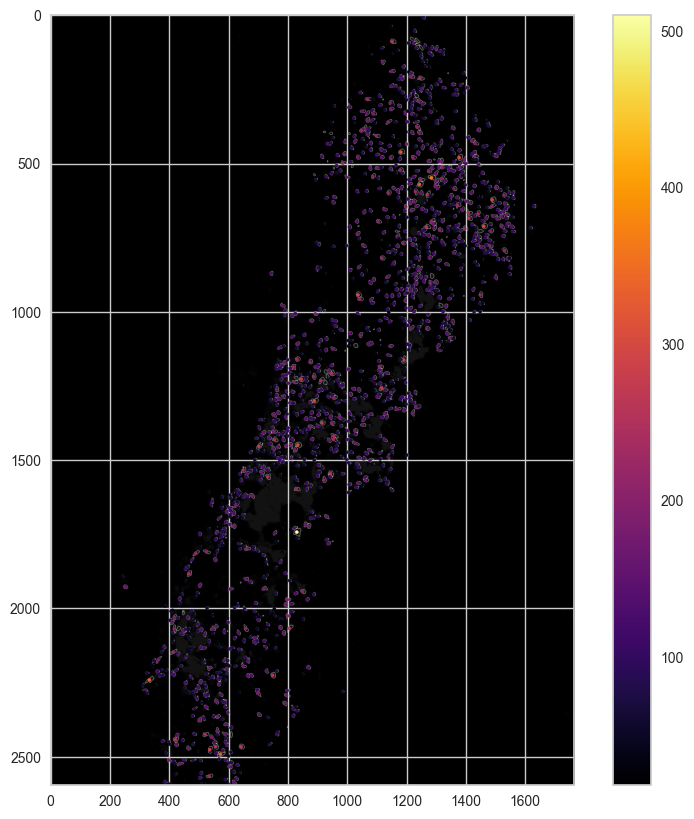

In [157]:
sp.pl.coordinates_on_image(
    df = df_reg_nn.loc[df_reg_nn['unique_region'] == 'reg003',:], 
    overlay_data = overlay_data1, color='area',  
    scale=False, # whether to scale to 1 or not
    dot_size=5,
    convert_to_grey=True, 
    fig_width=10, fig_height=10)

In [158]:
plt.rc('axes', grid=False)

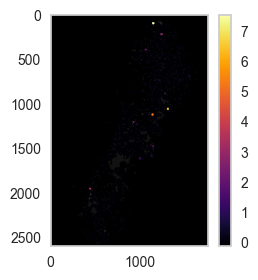

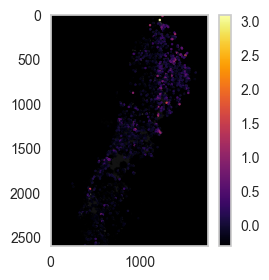

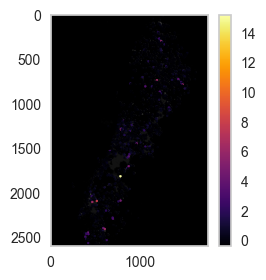

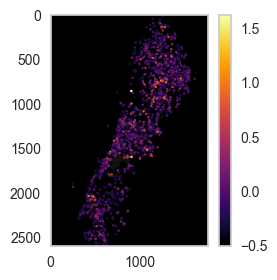

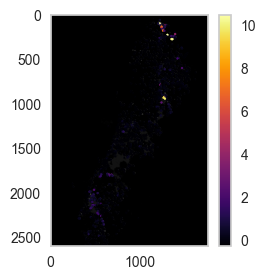

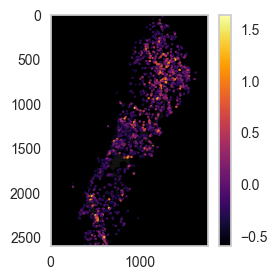

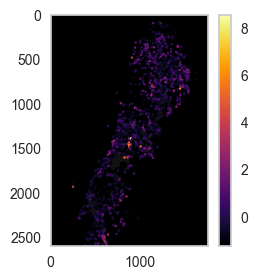

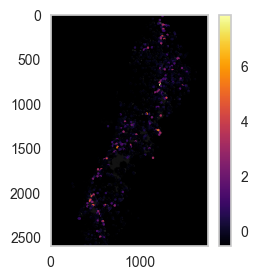

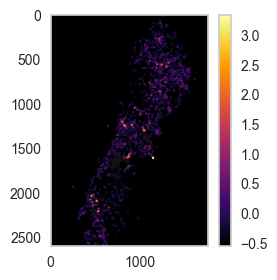

In [163]:
marker_list = ['Ki67', 'Keratin5', 'CD68', 'Podoplanin', 'SMA', 'CD107a', 'CLDN17',
       'CD34', 'HLA-DR']

for marker in marker_list:
    sp.pl.coordinates_on_image(
        df = df_reg_nn.loc[df_reg_nn['unique_region'] == 'reg003',:], 
        overlay_data = overlay_data1, 
        color=marker, 
        scale=False, # whether to scale to 1 or not
        dot_size=2,
        convert_to_grey=True, 
        fig_width=3, fig_height=3 )
